<a href="https://colab.research.google.com/github/JAZ201107/PyTorch-DL/blob/main/MaE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [14]:
from google.colab import userdata
import os

KaggleKey = userdata.get('KaggleKey')
KaggleUserName = userdata.get('KaggleUserName')

os.environ['KAGGLE_USERNAME'] = KaggleUserName
os.environ['KAGGLE_KEY'] = KaggleKey

!kaggle datasets download arjunashok33/miniimagenet

Dataset URL: https://www.kaggle.com/datasets/arjunashok33/miniimagenet
License(s): CC0-1.0
100% 6.26G/6.28G [01:35<00:00, 119MB/s]
100% 6.28G/6.28G [01:35<00:00, 70.3MB/s]


In [20]:
!unzip   /content/miniimagenet.zip -d ./data > /dev/null

In [33]:
!wget https://github.com/torch/tutorials/blob/master/7_imagenet_classification/synset_words.txt

--2024-12-10 13:15:41--  https://github.com/torch/tutorials/blob/master/7_imagenet_classification/synset_words.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘synset_words.txt.1’

synset_words.txt.1      [ <=>                ] 696.41K  --.-KB/s    in 0.06s   

2024-12-10 13:15:42 (10.8 MB/s) - ‘synset_words.txt.1’ saved [713120]



In [ ]:
# https://github.com/torch/tutorials/blob/master/7_imagenet_classification/synset_words.txt

In [37]:
CLASS_NAME_MAPPING = "/content/synset_words.txt"

In [38]:
def id_to_class():
    id_to_name = {}
    with open(CLASS_NAME_MAPPING, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                synset_id, name = parts
                # Take only the first English name (before the first comma)
                english_name = name.split(",")[0].strip()
                id_to_name[synset_id] = english_name
    return id_to_name

it_to_class_dic = id_to_class()
it_to_class_dic

{'n01440764': 'tench',
 'n01443537': 'goldfish',
 'n01484850': 'great white shark',
 'n01491361': 'tiger shark',
 'n01494475': 'hammerhead',
 'n01496331': 'electric ray',
 'n01498041': 'stingray',
 'n01514668': 'cock',
 'n01514859': 'hen',
 'n01518878': 'ostrich',
 'n01530575': 'brambling',
 'n01531178': 'goldfinch',
 'n01532829': 'house finch',
 'n01534433': 'junco',
 'n01537544': 'indigo bunting',
 'n01558993': 'robin',
 'n01560419': 'bulbul',
 'n01580077': 'jay',
 'n01582220': 'magpie',
 'n01592084': 'chickadee',
 'n01601694': 'water ouzel',
 'n01608432': 'kite',
 'n01614925': 'bald eagle',
 'n01616318': 'vulture',
 'n01622779': 'great grey owl',
 'n01629819': 'European fire salamander',
 'n01630670': 'common newt',
 'n01631663': 'eft',
 'n01632458': 'spotted salamander',
 'n01632777': 'axolotl',
 'n01641577': 'bullfrog',
 'n01644373': 'tree frog',
 'n01644900': 'tailed frog',
 'n01664065': 'loggerhead',
 'n01665541': 'leatherback turtle',
 'n01667114': 'mud turtle',
 'n01667778': '

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import numpy as np

import matplotlib.pyplot as plt

import einops

In [21]:
from PIL import Image

In [22]:
DATA_DIC = "/content/data"

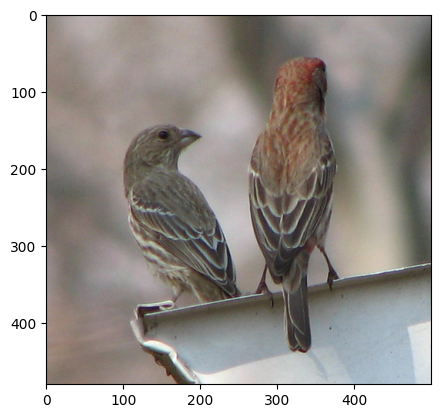

In [29]:
data = "/content/data/n01532829/n01532829_10104.JPEG"
image = Image.open(data)
plt.imshow(image);

In [31]:
classes = [d for d in os.listdir(DATA_DIC) if os.path.isdir(os.path.join(DATA_DIC, d))]
classes

['n02687172',
 'n04389033',
 'n01855672',
 'n04596742',
 'n02101006',
 'n02981792',
 'n03075370',
 'n02966193',
 'n02443484',
 'n02074367',
 'n04275548',
 'n13133613',
 'n07697537',
 'n01770081',
 'n02871525',
 'n02091831',
 'n03400231',
 'n04612504',
 'n02823428',
 'n01843383',
 'n03676483',
 'n02099601',
 'n04258138',
 'n01749939',
 'n02114548',
 'n03220513',
 'n03476684',
 'n02111277',
 'n02795169',
 'n04443257',
 'n03146219',
 'n02606052',
 'n03584254',
 'n03544143',
 'n07747607',
 'n02116738',
 'n01981276',
 'n01558993',
 'n04296562',
 'n06794110',
 'n02091244',
 'n01532829',
 'n04515003',
 'n02110063',
 'n04146614',
 'n01910747',
 'n04418357',
 'n02174001',
 'n04149813',
 'n01704323',
 'n04243546',
 'n03017168',
 'n03337140',
 'n03854065',
 'n03838899',
 'n03908618',
 'n01930112',
 'n03980874',
 'n02120079',
 'n04604644',
 'n04509417',
 'n02219486',
 'n03888605',
 'n03773504',
 'n04435653',
 'n04067472',
 'n03775546',
 'n02110341',
 'n03347037',
 'n07584110',
 'n03047690',
 'n039

In [39]:
import shutil
from sklearn.model_selection import train_test_split

from tqdm.autonotebook import tqdm

In [43]:
def split_train_val(train_ratio = 0.8):
    train_dir = os.path.join(DATA_DIC, 'train')
    val_dir = os.path.join(DATA_DIC, 'val')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Iterate through each class folder
    classes = [d for d in os.listdir(DATA_DIC) if os.path.isdir(os.path.join(DATA_DIC, d))]
    t = tqdm(classes, total = len(classes))
    for cls in t:
        cls_dir = os.path.join(DATA_DIC, cls)
        images = [f for f in os.listdir(cls_dir) if os.path.isfile(os.path.join(cls_dir, f))]

        # Split into training and validation
        train_images, val_images = train_test_split(images, train_size=train_ratio, random_state=42)

        # # Create subdirectories for the class in train and val folders
        # os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        # os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

        # Move images to the respective directories
        for img in train_images:
            shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, img))
        for img in val_images:
            shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, img))

    print(f"Dataset successfully split into {train_dir} (train) and {val_dir} (validation)")
    print(f"{len(os.listdir(train_dir))} training, {len(os.listdir(val_dir))} validation")

In [44]:
# split_train_val()

Dataset successfully split into /content/data/train (train) and /content/data/val (validation)
14880 training, 3720 validation


# Datasets and DataLoader

In [53]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [47]:
class MiniImageNetDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = os.path.join(data_dir, split)
        self.transform = transform
        self.image_names = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_names[idx])

        image = Image.open(img_path).convert('RGB')  # Convert to RGB
        if self.transform:
            image = self.transform(image)
        return image

In [48]:
transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet mean and std
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet mean and std
    ]),
}

In [51]:
datasets = {
    key: MiniImageNetDataset(DATA_DIC,  key, transforms[key])
    for key in ('train', 'val')
}

In [54]:
dataloaders = {
    key: DataLoader(datasets[key], batch_size=32, shuffle=True, num_workers=2)
    for key in ('train', 'val')
}

In [55]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x78f26f827c70>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x78f26f826a10>}

In [56]:
def random_masking(x, mask_ratio=0.75):
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))

    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore

In [57]:
def patchify(imgs: torch.Tensor, patch_size=16):
    assert (
        imgs.shape[2] % patch_size == 0
        and imgs.shape[3] % patch_size == 0
        and imgs.shape[2] == imgs.shape[3]
    ), "image size must be divisible by patch size"

    h = w = imgs.shape[2] // patch_size
    # x = imgs.reshape(imgs.shape[0], 3, h, patch_size, w, patch_size)
    x = einops.rearrange(imgs, "n c (h q) (w p) -> n (h w) c q p", h=h, w=w)

    return x


def unpatchify(imgs, patch_size=16):
    h = w = int(math.sqrt(imgs.shape[1]))
    x = imgs.reshape(imgs.shape[0], h, w, 3, patch_size, patch_size)
    x = torch.einsum("n h w c p q -> n c (h p) (w q)", x)

    return x

In [67]:
# image = Image.open("test.jpg")
# image = image.resize((256, 256))
# print(image.size)

In [68]:
# from torchvision import transforms

# train_transforms = transforms.Compose(
#     [
#         transforms.Resize(224),
#         transforms.ToTensor(),
#     ]
# )

In [69]:
# image = Image.open("test.jpg")
# image = train_transforms(image)
# image = patchify(image.unsqueeze(0))

In [70]:
# image = image.squeeze(0)
# image.size()

In [71]:
import torchvision

In [72]:
# fig, ax = plt.subplots(14, 1, figsize=(10, 10))
# for i in range(14):
#     img_grid = torchvision.utils.make_grid(
#         image[i * 14 : (i + 1) * 14], nrow=14, pad_value=0.5
#     )
#     img_grid = img_grid.permute(1, 2, 0)
#     ax[i].imshow(img_grid)
#     ax[i].axis("off")

In [73]:
image.size()

TypeError: 'tuple' object is not callable

In [84]:
# mask_ratio = 0.75  # 75% masking

# # Number of patches to mask
# num_patches = image.size(0)  # 196 patches
# num_masked = int(mask_ratio * num_patches)

# # Generate random indices for masking
# masked_indices = torch.randperm(num_patches)[:num_masked]

# # Create a mask (boolean)
# mask = torch.ones(num_patches, dtype=torch.bool)  # Start with all True
# mask[masked_indices] = False  # Set masked indices to False

# # Apply the mask (masked patches become 0)
# masked_tensor = image.clone()
# masked_tensor[~mask] = 0  # Masked patches set to 0

# # Output
# print(f"Original Tensor Shape: {image.shape}")
# print(f"Masked Tensor Shape: {masked_tensor.shape}")
# print(f"Number of Patches Masked: {num_masked}")

In [85]:
def plot_image(img):
    assert img.dim() == 4 and img.size(1) == 3, "Invalid image tensor shape"
    fig, ax = plt.subplots(14, 1, figsize=(10, 10))
    for i in range(14):
        img_grid = torchvision.utils.make_grid(
            img[i * 14 : (i + 1) * 14], nrow=14, pad_value=0.7
        )
        img_grid = img_grid.permute(1, 2, 0)
        ax[i].imshow(img_grid)
        ax[i].axis("off")

In [88]:
# plot_image(image)

In [89]:
class PatchEmbed(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.img_size = config.img_size
        self.patch_size = config.patch_size
        self.in_chans = config.in_chans
        self.embed_dim = config.embed_dim

        self.proj = nn.Conv2d(
            in_channels=self.in_chans,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
        )

    def forward(self, x):
        # (B, C, H, W) -> (B, E, P, P)
        x = self.proj(x)
        # (B, E, P, P) -> (B,  E, P * P)
        x = x.flatten(2)
        # (B, E, P * P) -> (B, P * P, E)
        x = x.transpose(1, 2)
        return x

## ViT Block


In [90]:
class ViTBlock(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.attn = MultiHeadAttention(config)
        self.ffn = FeedForward(config)

        self.ln1 = nn.LayerNorm(config.hidden_size)
        self.ln2 = nn.LayerNorm(config.hidden_size)

    def forward(self, x):

        residual = x
        x = self.ln1(self.attn(x))
        x = x + residual

        residual = x
        x = self.ln2(self.ffn(x))
        x = x + residual

        return x

## Multi Head Attention


In [91]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        assert (
            self.hidden_size % self.num_heads == 0
        ), "hidden size must be divisible by num    heads"
        self.head_dim = self.hidden_size // self.num_heads

        self.qkv_lin = nn.Linear(config.hidden_size, 3 * config.hidden_size)
        self.out_lin = nn.Linear(config.hidden_size, config.hidden_size)

        self.dropout = nn.Dropout(config.attention_dropout)

    def forward(self, x):
        B, _, _ = x.size()
        q, k, v = self.qkv_lin(x).chunk(3, dim=-1)

        q = q.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, -1, self.num_heads, self.head_dim).transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        x = attn @ v

        x = x.transpose(1, 2).contiguous().view(B, -1, self.hidden_size)

        x = self.out_lin(x)
        return x

In [92]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.Linear(config.hidden_size, config.ffn_hidden_size)
        self.ln2 = nn.Linear(config.ffn_hidden_size, config.hidden_size)

        self.norm1 = nn.LayerNorm(config.ffn_hidden_size)
        self.norm2 = nn.LayerNorm(config.hidden_size)

    def forward(self, x):
        x = self.norm1(self.ln1(x))
        x = F.gelu(x)
        x = self.norm2(self.ln2(x))

        return x

# MAE Encoder


In [93]:
class MaEEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.layers = nn.ModuleList(
            [ViTBlock(config) for _ in range(config.enc_num_layers)]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

## MAE Decoder


In [94]:
class MaEDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.layers = nn.ModuleList(
            [ViTBlock(config) for _ in range(config.dec_num_layers)]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

# MAE Model


In [95]:
class MaskedAutoencoderViT(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.patch_embed = PatchEmbed(config)

        self.cls_token = nn.Parameter(torch.randn(1, 1, config.hidden_size))

        self.enc_pos_embed = nn.Parameter(
            torch.randn(1, config.num_patches, config.hidden_size),
            requires_grad=False,
        )

        self.num_patches = config.num_patches

        self.encoder = MaEEncoder(config)
        self.decoder = MaEDecoder(config)

        self.blocks = nn.ModuleList(
            [ViTBlock(config) for _ in range(config.num_layers)]
        )
        self.norm = nn.LayerNorm(config.hidden_size)

        # Decoder
        self.decoder_embed = nn.Linear(
            config.hidden_size, config.decoder_hidden_size, bias=True
        )

        self.mask_token = nn.Parameter(torch.zeros(1, 1, config.decoder_hidden_size))
        self.decoder_pos_embed = nn.Parameter(
            torch.randn(1, self.num_patches + 1, config.decoder_hidden_size),
            requires_grad=False,
        )  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList(
            [ViTBlock(config) for _ in range(config.num_layers)]
        )

        self.decoder_norm = nn.LayerNorm(config.decoder_hidden_size)
        self.decoder = nn.Linear(
            config.decoder_hidden_size,
            config.patch_size**2 * config.in_chans,
            bias=True,
        )

        self.norm_pix_loss = False
        self._init_positional_embedding()

        self.initialize_parameters()

    def initialize_parameters(self):

        w = self.patch_embed.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        torch.nn.init.normal_(self.cls_token, std=0.02)
        torch.nn.init.normal_(self.mask_token, std=0.02)

        # Initialize the Linear and LayerNorm parameters
        self.apply(self._init_weight)

    def _init_positional_embedding(self):
        pos_embed = get_2d_sincos_pos_embed(
            self.enc_pos_embed.shape[-1],
            int(self.num_patches**0.5),
            cls_token=False,
        )
        self.enc_pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        pos_embed = get_2d_sincos_pos_embed(
            self.decoder_pos_embed.shape[-1],
            int(self.num_patches**0.5),
            cls_token=True,
        )

        self.decoder_pos_embed.data.copy_(
            torch.from_numpy(pos_embed).float().unsqueeze(0)
        )

        # self.register_buffer("decoder_pos_embed", self.decoder_pos_embed)
        # self.register_buffer("pos_embed", self.pos_embed)

    def _init_weight(self, module):
        if isinstance(module, nn.Linear):
            # torch.nn.init.xavier_uniform_(module.weight)
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                # torch.nn.init.constant_(module.bias, 0)
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, x):
        B, C, H, W = x.shape

        # Position Encoding
        x = self.patch_embed(x)
        x = x + self.enc_pos_embed

        # Random Making
        x, mask, ids_restore = random_masking(x, 0.75)

        # Encoder
        x = self.encoder(x)

        # Decoder
        ## Add Mask Token back to the representation
        x = self.decoder_embed(x)

        mask_tokens = self.mask_token.repeat(
            B, ids_restore.shape[1] + 1 - x.shape[1], 1
        )
        x_ = torch.cat((x[:, 1:, :], mask_tokens), dim=1)
        x_ = torch.gather(
            x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x_.shape[-1])
        )
        x = torch.cat((x[:, :1, :], x_), dim=1)

        x = x + self.decoder_pos_embed

        x = self.decoder(x)

        x = x[:, 1:, :]

        return x, mask

In [96]:
def loss(imgs, pred, mask):
    target = patchify(imgs, 16)

    loss = (pred - target) ** 2
    loss = loss.mean(dim=-1)
    loss = (loss * mask).sum() / mask.sum()
    return loss

In [97]:
from dataclasses import dataclass


@dataclass
class Config:
    embed_dim: int = 256

    hidden_size: int = 256
    img_size = 224
    num_heads: int = 8
    num_layers: int = 6
    enc_num_layers: int = 6
    dec_num_layers: int = 6
    ffn_hidden_size: int = 512
    decoder_hidden_size: int = 256
    attention_dropout: float = 0.1
    patch_size: int = 16
    in_chans: int = 3
    num_patches: int = (img_size // patch_size) ** 2

In [98]:
import numpy as np


def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [99]:
# Test Model
x = torch.randn(4, 3, 224, 224)
model = MaskedAutoencoderViT(Config)

pred, mask = model(x)

# Training Process


In [100]:
for batch in dataloaders["train"]:
    with torch.cuda.amp.autocast():
        pred, mask = model(batch)
        loss = loss(batch, pred, mask)

<ipython-input-100-2204350ad906>:2: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
class Trainer:
    def __init__(
            self,
            model,
            dataloaders
    ):
        self.model = model
        self.dataloaders = dataloaders

    def train_one_epoch()